In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

from ChangTools.plotting import prettycolors

In [12]:
from scipy import interpolate, signal
import matplotlib.font_manager as fm


# We need a special font for the code below.  It can be downloaded this way:
import os
import urllib2
if not os.path.exists('Humor-Sans.ttf'):
    fhandle = urllib2.urlopen('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.read())

In [13]:
def xkcd_line(x, y, xlim=None, ylim=None,
              mag=1.0, f1=30, f2=0.05, f3=15):
    """
    Mimic a hand-drawn line from (x, y) data

    Parameters
    ----------
    x, y : array_like
        arrays to be modified
    xlim, ylim : data range
        the assumed plot range for the modification.  If not specified,
        they will be guessed from the  data
    mag : float
        magnitude of distortions
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    
    Returns
    -------
    x, y : ndarrays
        The modified lines
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # get limits for rescaling
    if xlim is None:
        xlim = (x.min(), x.max())
    if ylim is None:
        ylim = (y.min(), y.max())

    if xlim[1] == xlim[0]:
        xlim = ylim
        
    if ylim[1] == ylim[0]:
        ylim = xlim

    # scale the data
    x_scaled = (x - xlim[0]) * 1. / (xlim[1] - xlim[0])
    y_scaled = (y - ylim[0]) * 1. / (ylim[1] - ylim[0])

    # compute the total distance along the path
    dx = x_scaled[1:] - x_scaled[:-1]
    dy = y_scaled[1:] - y_scaled[:-1]
    dist_tot = np.sum(np.sqrt(dx * dx + dy * dy))

    # number of interpolated points is proportional to the distance
    Nu = int(200 * dist_tot)
    u = np.arange(-1, Nu + 1) * 1. / (Nu - 1)

    # interpolate curve at sampled points
    k = min(3, len(x) - 1)
    res = interpolate.splprep([x_scaled, y_scaled], s=0, k=k)
    x_int, y_int = interpolate.splev(u, res[0]) 

    # we'll perturb perpendicular to the drawn line
    dx = x_int[2:] - x_int[:-2]
    dy = y_int[2:] - y_int[:-2]
    dist = np.sqrt(dx * dx + dy * dy)

    # create a filtered perturbation
    coeffs = mag * np.random.normal(0, 0.01, len(x_int) - 2)
    b = signal.firwin(f1, f2 * dist_tot, window=('kaiser', f3))
    response = signal.lfilter(b, 1, coeffs)

    x_int[1:-1] += response * dy / dist
    y_int[1:-1] += response * dx / dist

    # un-scale data
    x_int = x_int[1:-1] * (xlim[1] - xlim[0]) + xlim[0]
    y_int = y_int[1:-1] * (ylim[1] - ylim[0]) + ylim[0]
    
    return x_int, y_int

In [152]:
def XKCDify(ax, mag=1.0,
            f1=50, f2=0.01, f3=15,
            bgcolor='w',
            xaxis_loc=None,
            yaxis_loc=None,
            xaxis_arrow='+',
            yaxis_arrow='+',
            ax_extend=0.1,
            expand_axes=False):
    """Make axis look hand-drawn

    This adjusts all lines, text, legends, and axes in the figure to look
    like xkcd plots.  Other plot elements are not modified.
    
    Parameters
    ----------
    ax : Axes instance
        the axes to be modified.
    mag : float
        the magnitude of the distortion
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    xaxis_loc, yaxis_log : float
        The locations to draw the x and y axes.  If not specified, they
        will be drawn from the bottom left of the plot
    xaxis_arrow, yaxis_arrow : str
        where to draw arrows on the x/y axes.  Options are '+', '-', '+-', or ''
    ax_extend : float
        How far (fractionally) to extend the drawn axes beyond the original
        axes limits
    expand_axes : bool
        if True, then expand axes to fill the figure (useful if there is only
        a single axes in the figure)
    """
    # Get axes aspect
    ext = ax.get_window_extent().extents
    aspect = (ext[3] - ext[1]) / (ext[2] - ext[0])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - xlim[0]

    xax_lim = (xlim[0] - ax_extend * xspan,
               xlim[1] + ax_extend * xspan)
    yax_lim = (ylim[0] - ax_extend * yspan,
               ylim[1] + ax_extend * yspan)

    if xaxis_loc is None:
        xaxis_loc = ylim[0]

    if yaxis_loc is None:
        yaxis_loc = xlim[0]

    # Draw axes
    xaxis = pl.Line2D([xax_lim[0], xax_lim[1]], [xaxis_loc, xaxis_loc],
                      linestyle='-', color='k')
    yaxis = pl.Line2D([yaxis_loc, yaxis_loc], [yax_lim[0], yax_lim[1]],
                      linestyle='-', color='k')


    # Label axes3, 0.5, 'hello', fontsize=14)
    ax.text(0.75 * xax_lim[1], xaxis_loc - 0.05 * yspan, ax.get_xlabel(),
            fontsize=14, ha='right', va='top', rotation=0)
    ax.text(yaxis_loc - 0.02 * xspan, 0.75*yax_lim[1], ax.get_ylabel(),
            fontsize=14, ha='right', va='top', rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add title
    ax.text(0.5 * (xax_lim[1] + xax_lim[0]), yax_lim[1],
            ax.get_title(),
            ha='center', va='bottom', fontsize=16)
    ax.set_title('')

    Nlines = len(ax.lines)
    lines = [xaxis, yaxis] + [ax.lines.pop(0) for i in range(Nlines)]

    for line in lines:
        x, y = line.get_data()

        x_int, y_int = xkcd_line(x, y, xlim, ylim,
                                 mag, f1, f2, f3)

        # create foreground and background line
        lw = line.get_linewidth()
        line.set_linewidth(2 * lw)
        line.set_data(x_int, y_int)

        # don't add background line for axes
        '''
        if (line is not xaxis) and (line is not yaxis):
            line_bg = pl.Line2D(x_int, y_int, color=bgcolor,
                                linewidth=8 * lw)

            ax.add_line(line_bg)
        '''
        ax.add_line(line)

    # Draw arrow-heads at the end of axes lines
    arr1 = 0.03 * np.array([-1, 0, -1])
    arr2 = 0.02 * np.array([-1, 0, 1])

    arr1[::2] += np.random.normal(0, 0.005, 2)
    arr2[::2] += np.random.normal(0, 0.005, 2)

    x, y = xaxis.get_data()
    if '+' in str(xaxis_arrow):
        ax.plot(x[-1] + arr1 * xspan * aspect,
                y[-1] + arr2 * yspan,
                color='k', lw=2)
    if '-' in str(xaxis_arrow):
        ax.plot(x[0] - arr1 * xspan * aspect,
                y[0] - arr2 * yspan,
                color='k', lw=2)

    x, y = yaxis.get_data()
    if '+' in str(yaxis_arrow):
        ax.plot(x[-1] + arr2 * xspan * aspect,
                y[-1] + arr1 * yspan,
                color='k', lw=2)
    if '-' in str(yaxis_arrow):
        ax.plot(x[0] - arr2 * xspan * aspect,
                y[0] - arr1 * yspan,
                color='k', lw=2)

    # Change all the fonts to humor-sans.
    #prop = fm.FontProperties(fname='/Users/hahn/Library/Fonts/daniel.ttf')#, size=30)#'Humor-Sans.ttf', size=16)
    #for text in ax.texts:
    #    text.set_fontproperties(prop)
    
    # modify legend
    leg = ax.get_legend()
    if leg is not None:
        leg.set_frame_on(False)
        
        for child in leg.get_children():
            if isinstance(child, pl.Line2D):
                x, y = child.get_data()
                child.set_data(xkcd_line(x, y, mag=10, f1=100, f2=0.001))
                child.set_linewidth(2 * child.get_linewidth())
            if isinstance(child, pl.Text):
                child.set_fontproperties(prop)
    
    # Set the axis limits
    ax.set_xlim(xax_lim[0] - 0.1 * xspan,
                xax_lim[1] + 0.1 * xspan)
    ax.set_ylim(yax_lim[0] - 0.1 * yspan,
                yax_lim[1] + 0.1 * yspan)

    # adjust the axes
    ax.set_xticks([])
    ax.set_yticks([])      

    if expand_axes:
        ax.figure.set_facecolor(bgcolor)
        ax.set_axis_off()
        ax.set_position([0, 0, 1, 1])
    
    return ax

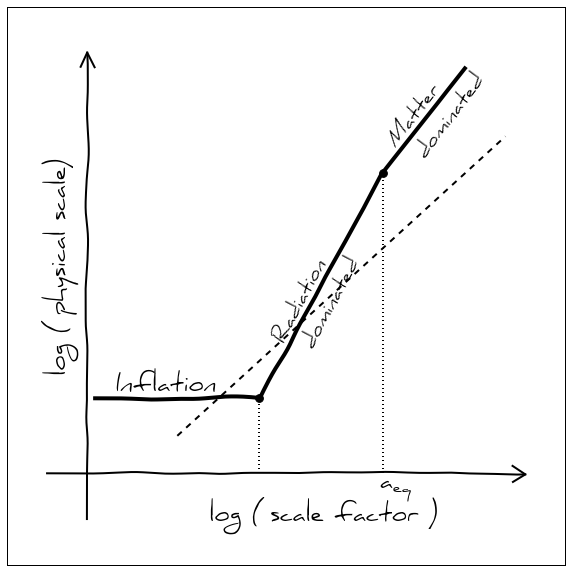

In [159]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)

def hubble_rad(x): 
    if x < 1.: 
        return 1. 
    elif x >= 1 and x < 2.5: 
        return 2*x-1.
    elif x >= 2.5: 
        return 1.4 * (x - 2.5) + 4.

x_arr = np.arange(-1., 3.51, 0.01)
sub.plot(x_arr, [hubble_rad(x) for x in x_arr], lw=2, ls='-', c='k')
sub.scatter([1., 2.5], [hubble_rad(1.), hubble_rad(2.5)], s=60, c='k')

sub.plot([0., 4.], np.array([0., 4.])+0.5, lw=1, ls='--', c='k')

sub.vlines([1.], [0.], [hubble_rad(1.)], linewidth=2, linestyle=':')
sub.vlines([2.5], [0.], [hubble_rad(2.5)], linewidth=2, linestyle=':')

sub.text(-0.75, 1.1, 'Inflation')
text_rad = sub.text(1.1, 2.5, 'Radiation\n dominated', rotation=62)
text_mat = sub.text(2.5, 5.0, 'Matter\n dominated', rotation=53)
text_aeq = sub.text(2.45, -0.2, 'a$_\mathregular{eq}$')#, rotation=53)

prop = fm.FontProperties(fname='/Users/hahn/Library/Fonts/daniel.ttf', size=20)#, size=30)#'Humor-Sans.ttf', size=16)

text_rad.set_fontproperties(prop)
text_mat.set_fontproperties(prop)

prop = fm.FontProperties(fname='/Users/hahn/Library/Fonts/daniel.ttf', size=25)#, size=30)#'Humor-Sans.ttf', size=16)

text_aeq.set_fontproperties(prop)

changed_text = [text_rad, text_mat, text_aeq] 

#for text in sub.texts:
#    text.set_fontproperties(prop)
#    changed_text.append(text)

#x_mat = np.arange(2., )
sub.set_xlim([-1.1, 3.75])
sub.set_xlabel('log ( scale factor )', fontsize=25)
sub.set_ylim([0., 5.])
sub.set_ylabel('log ( physical scale)', fontsize=25)
XKCDify(sub)
prop = fm.FontProperties(fname='/Users/hahn/Library/Fonts/daniel.ttf', size=25)#, size=30)#'Humor-Sans.ttf', size=16)
for text in sub.texts:
    if text not in changed_text:
        text.set_fontproperties(prop)

fig.savefig('figs/lifo.png', bbox_inches='tight', dpi=250)